In [5]:
import os
BAR = 'Barcodes_1d'
ROOT = open('../root').read().strip()
print ROOT
img_path = os.path.join(ROOT, 'common')
print img_path
anno_path = os.path.join(ROOT, BAR, 'annotations.json')
print anno_path
empty_path = os.path.join(ROOT, 'Empty', 'annotations.json')
print empty_path

/home/nik-kochetov/work
/home/nik-kochetov/work/common
/home/nik-kochetov/work/Barcodes_1d/annotations.json
/home/nik-kochetov/work/Empty/annotations.json


In [2]:
import keras
import os
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, Reshape
from keras.applications.vgg16 import VGG16
import math
import numpy as np
%matplotlib notebook

Using TensorFlow backend.


In [3]:
import model
reload(model)
from model import PixelsModel
pixels_model = PixelsModel()

In [5]:
pixels_model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, None, None, 3 128         conv1[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, None, None, 3 0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv2 (Con

In [6]:
import json
with open(anno_path) as f:
    annos = json.loads(f.read())
print len(annos)
print annos[0]

with open(empty_path) as f:
    empty_annos = json.loads(f.read())
print len(empty_annos)
print empty_annos[0]

all_annos = annos + empty_annos[:len(empty_annos) / 2]

8111
{u'name': u'0001.jpg', u'shape': [3585, 2661, 3], u'Rects': [[594, 1081, 326, 575], [568, 1054, 1131, 1382], [593, 1074, 718, 968], [572, 1057, 1566, 1817], [564, 1050, 1964, 2217], [567, 1048, 2437, 2691]], u'path': u'Barcodes_1d/UPC-E', u'id': u'0001', u'Types': [u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE']}
10156
{u'Rects': [], u'path': u'Empty', u'shape': [4400, 3400, 3], u'name': u'9468_020.4B.tif.jpg', u'Types': []}


In [7]:
import generator
reload(generator)
from generator import Generator
pixels_generator = Generator(ROOT, pixels_model)

In [11]:
res = pixels_generator.generate_pixels(all_annos, 512*512*1, True)

In [12]:
x, y = res.next()
print x.shape, y.shape

next batch:
('img:', u'Barcodes_1d/Interleaved 2 of 5 (1)/0005.jpg')
('window: ', Rect(0, 251, 2048, 2299))
(1, 512, 512, 1) (1, 16, 16, 2)


/home/nik-kochetov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1, 512, 512, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [6]:
from keras import backend as K

def nice_binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=True), axis=-1)

def nice_categorical_crossentropy(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred, from_logits=True)

In [33]:
y_true = np.array([[0.5, 0, 0.5, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=float)
y_pred = np.array([[100, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=float)

res = nice_categorical_crossentropy(y_true, y_pred)

In [34]:
import tensorflow as tf
sess = tf.InteractiveSession()

# Some tensor we want to print the value of
a = tf.constant([1.0, 3.0])

# Add print operation
a = tf.Print(a, [a], message="This is a: ")

# Add more elements of the graph using a
b = tf.add(a, a)

b.eval()
res.eval()

array([ 50.        ,   0.74366838,   0.74366838,   0.74366838])

In [32]:
loss_map = {'class': nice_binary_crossentropy}

In [33]:
import time
date = time.strftime("%d-%m-%Y")
date

'04-03-2018'

In [34]:
pixels_model.model.compile(optimizer='adam', loss=loss_map)

In [35]:
from keras import backend as K
K.backend() == 'tensorflow'

True

In [36]:
def dump_gen(x, y):
    while True:
        yield x, y
        
dump = dump_gen(x, y)

In [76]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

255.0 0.0


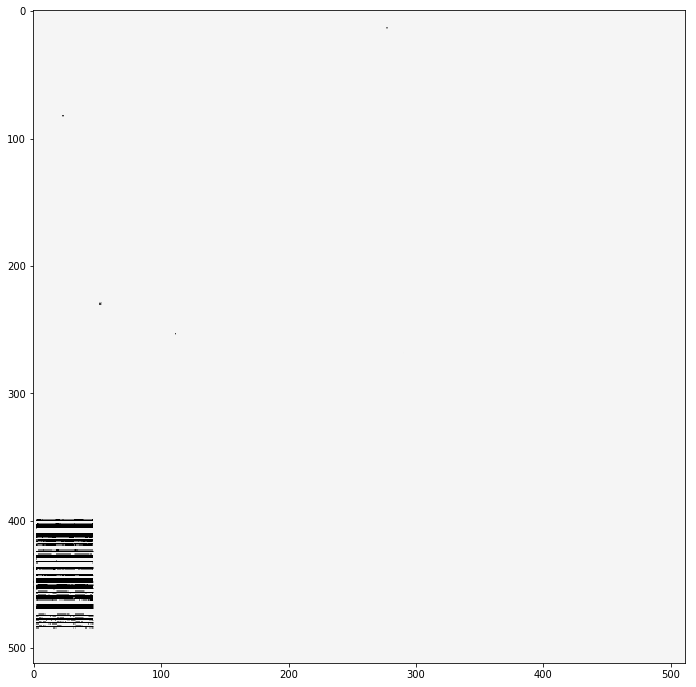

In [77]:
def show_img_from_gen(ax, gen, ps=0):
    def unprocess(y):
            x = np.copy(y)
            # Zero-decenter by mean pixel
            x[:, :, :, 0] += 103.939
            x[:, :, :, 1] += 116.779
            x[:, :, :, 2] += 123.68

            # 'BGR'->'RGB'
            x = x[:, :, :, ::-1]
            print np.max(x), np.min(x)
            return x / 265.0


    ax.imshow(np.reshape(unprocess(gen[0]['input'])[ps], gen[0]['input'].shape[1:]))
    
    
fig, ax = plt.subplots(figsize=(12, 12))
show_img_from_gen(ax, next(dump), ps=0)

In [37]:
import tensorflow as tf
import tf_callback
reload(tf_callback)
from tf_callback import MyTensorBoard

In [38]:
names = 'model.' + date + '.gen3_pixels.ssd.{epoch:02d}.hdf5'
save_callback = keras.callbacks.ModelCheckpoint(names, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# csv_logger = keras.callbacks.CSVLogger('log.csv', append=False, separator='\t')
tensor_board = MyTensorBoard(log_dir='./logs', histogram_freq=0, batch_size=2, write_graph=False, 
                            write_grads=False, write_images=False, embeddings_freq=0, 
                            embeddings_layer_names=None, embeddings_metadata=None, write_batch_performance=True)

In [39]:
pixels_model.model.fit_generator(pixels_generator.generate_pixels(anno, 512),
        steps_per_epoch= min(20, len(anno)) , epochs=20, 
        callbacks=[save_callback, tensor_board]) #, csv_logger, plot_losses])

Epoch 1/20
19/20 [===========================>..] - ETA: 3:18 - loss: 0.3128
Epoch 00001: saving model to model.04-03-2018.gen3_pixels.ssd.01.hdf5
20/20 [==============================] - 4017s 201s/step - loss: 0.3148
Epoch 2/20


KeyboardInterrupt: 

In [90]:
yy = [my_sigmoid(t) for t in ssd_model.model.predict(x['input'])]

/home/nik-kochetov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [91]:
for t in yy:
    print t.shape

(1, 15, 15, 3)
(1, 15, 15, 3)
(1, 15, 15, 2)


In [93]:
print np.around(yy[-1][0,:,:,0], decimals=2)
print np.around(yy[-1][0,:,:,1], decimals=2)

[[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 0.82999998  0.99000001  1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 0.58999997  0.77999997  0.94999999  1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 0.55000001  0.63999999  0.75999999  0.94        1.          1.          1.
   1.          1.          1.          1.          1.          1.  

In [29]:
img_input = Input(shape=(256,256,3), name='input')


x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

# Note: vgg16 has 5 Blocks. Block 6 adds trainable params.

# Block 6
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block6_conv1')(x)
x = Conv2D(64, (2, 2), strides=(1, 1), name='block6_pool')(x)

cls_out = []


cls_out.append(Conv2D(2, (20, 20), padding='same', name='class')(x))
# cls_out.append(x)

# Create model.
inputs = img_input
tmp_model = Model(inputs, cls_out, name='ssd')

In [48]:
tmp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
__________

In [46]:
xx, yy =  res.next()

next batch:
img: Barcodes_1d/Upc-A 2ndScanClearLowDamaged/0086.jpg
window:  Rect(29, 522, 2077, 2570)
tensors: [(1, 1, 0.271484375, 0.5068359375, 1.0, 0.818359375, 0.22694969177246094), (2, 1, 0.271484375, 0.0068359375, 1.0, 0.318359375, 0.22694969177246094), (1, 2, 0.0, 0.5068359375, 0.5341796875, 0.818359375, 0.16640949249267578), (2, 2, 0.0, 0.0068359375, 0.5341796875, 0.318359375, 0.16640949249267578)]
img: Barcodes_1d/Upc-A 3rdScanWithTextHeavyDamaged/0055.jpg
window:  Rect(561, 1004, 1585, 2028)
tensors: [(2, 0, 0.642578125, 0.373046875, 1.0, 0.66015625, 0.10261917114257812), (2, 1, 0.142578125, 0.373046875, 0.833984375, 0.66015625, 0.19850921630859375)]
img: Barcodes_1d/Upc-A 3rdScanWithTextHeavyDamaged/0055.jpg
window:  Rect(194, 1439, 2242, 3487)
tensors: [(0, 0, 0.6796875, 0.26171875, 1.0, 0.4052734375, 0.04598236083984375), (0, 1, 0.1796875, 0.26171875, 0.525390625, 0.4052734375, 0.04962730407714844)]
img: Barcodes_1d/Code 128C/0325.jpg
window:  Rect(100, 976, 1124, 2000)
te

In [47]:
#xx = x # np.random.uniform(size=(1, 64, 64, 3))
#yy = y  # np.random.uniform(size=(1, 15, 15, 1))
dump2 = dump_gen(xx['input'][:1, :, :, :], yy['class'][:1, :, :, :])
print next(dump2)[0].shape, next(dump2)[1].shape

(1, 256, 256, 3) (1, 7, 7, 2)


In [52]:
tmp_model.compile(optimizer='adam', loss={'class': nice_categorical_crossentropy}) #'binary_crossentropy'})

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [53]:
tmp_model.fit_generator( dump2, #ssd_generator.generate(anno, 512),
        steps_per_epoch= min(20, len(anno)) , epochs=20, 
        callbacks=[]) #, tensor_board]) #, csv_logger, plot_losses])

Epoch 1/20
20/20 [==============================] - 18s 889ms/step - loss: 0.2803
Epoch 2/20
10/20 [==============>...............] - ETA: 8s - loss: 1.3648e-05

KeyboardInterrupt: 

In [49]:
print next(dump2)[1][0,:,:,0]

[[ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  0.  0.  1.  1.  1.  1.]
 [ 1.  0.  0.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.]]


In [50]:
print next(dump2)[0].shape

def my_sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

yy = [my_sigmoid(tmp_model.predict(next(dump2)[0]))]

(1, 256, 256, 3)


In [51]:
for t in yy:
    print t.shape

(1, 7, 7, 2)


In [125]:
print np.around(next(dump2)[1][0,:,:,0] - yy[-1][0,:,:,0], decimals=3)

[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -0.  0.]]


In [127]:
a = next(dump2)[1][0,:,:,0]
b = yy[-1][0,:,:,0]
eps = 1e-7
b = np.maximum(eps, np.minimum(1 - eps, b))
print a * np.log(b) + (1 - a) * np.log(1 - b)
print np.sum(a * np.log(b) + (1 - a) * np.log(1 - b)) / (7 * 7) 

[[ -1.19209304e-07  -1.19209304e-07  -1.19209304e-07  -1.19209304e-07
   -1.19209304e-07  -1.19209304e-07  -1.19209304e-07]
 [ -1.19209304e-07  -1.19209304e-07  -1.19209304e-07  -1.19209304e-07
   -1.19209304e-07  -1.19209304e-07  -1.19209304e-07]
 [ -1.19209304e-07  -1.19209304e-07  -1.19209304e-07  -1.19209304e-07
   -1.19209304e-07  -1.19209304e-07  -1.19209304e-07]
 [ -1.19209304e-07  -1.19209304e-07  -1.19209304e-07  -1.19209304e-07
   -1.19209304e-07  -1.19209304e-07  -1.19209304e-07]
 [ -1.19209304e-07  -1.19209304e-07  -1.19209304e-07  -1.19209304e-07
   -1.19209304e-07  -1.19209304e-07  -1.19209304e-07]
 [ -1.19209304e-07  -1.19209304e-07  -1.19209304e-07  -1.19209304e-07
   -1.19209304e-07  -1.19209304e-07  -1.19209304e-07]
 [ -1.19209304e-07  -1.19209304e-07  -1.19209304e-07  -1.19209304e-07
   -1.19209304e-07  -1.19209304e-07  -1.19209304e-07]]
-1.19209303762e-07


In [128]:
print np.sort(np.ndarray.flatten(np.abs(next(dump2)[1][0,:,:,0] - yy[-1][0,:,:,0])))

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.66643520e-34
   3.15308315e-29]


In [126]:
print np.around(yy[-1][0,:,:,0], decimals=3)
print yy[-1][0,:,:,1]

[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


IndexError: index 1 is out of bounds for axis 3 with size 1

In [ ]:
ssd_model.model.save_weights("model.h5")

In [16]:
# updatable plot
# a minimal example (sort of)

import matplotlib.pyplot as plt

class Row:
    def __init__(self, agg=10, level_size=10):
        self.agg = agg
        self.level_size = level_size
        self.batch = []
        self.levels = []
        
    def _add(self, val, level=0):
        if len(self.levels) == level:
            self.levels.append([])
        self.levels[level].append(val)
        if len(self.levels[level]) >= 2 * self.level_size:
            self._add(np.mean(self.levels[level][:-self.level_size]), level + 1)
            self.levels[level] = self.levels[level][-self.level_size:]
        
    def append(self, val):
        self.batch.append(val)
        if len(self.batch) > self.agg:
            self.batch = self.batch[1:]
        self._add(np.mean(self.batch))
            
    def get(self):
        #print self.levels
        res = []
        for vals in self.levels:
            res = vals + res
        return -np.log(res)
        

class PlotLosses(keras.callbacks.Callback):
    
    def __init__(self, ssd_model):
        self.ssd_model = ssd_model
    
    def on_train_begin(self, logs={}):
        self.bbox_losses = {}
        self.cls_losses = {}
        self.plot_legend = True
        
        for name in ssd_model.bbox_names:
            self.bbox_losses[name] = Row()
        for name in ssd_model.cls_names:
            self.cls_losses[name] = Row()
        
        self.fig, (self.ax_bbox, self.ax_cls) = plt.subplots(2, figsize=(12, 16))
        
    def _append(self, logs={}):
        for name in ssd_model.bbox_names:
                self.bbox_losses[name].append(logs.get(name + '_loss'))
        for name in ssd_model.cls_names:
                self.cls_losses[name].append(logs.get(name + '_loss'))
                
        
    def _plot(self):
        #clear_output(wait=True)
        
        self.ax_bbox.cla()
        self.ax_cls.cla()
        
        for name, vals in self.bbox_losses.items():
            self.ax_bbox.plot(vals.get(), label=name)
            
        for name, vals in self.cls_losses.items():
            self.ax_cls.plot(vals.get(), label=name)
        
        if self.plot_legend:
            bbox_to_anchor=(1.2, 1)
            self.ax_bbox.legend(bbox_to_anchor=bbox_to_anchor)
            self.ax_cls.legend(bbox_to_anchor=bbox_to_anchor)
            self.plot_legend = False
            
        self.fig.canvas.draw()
        
    def on_batch_end(self, batch, logs={}):
        #print logs
        self._append(logs)
        self._plot()
        

    def on_epoch_end(self, epoch, logs={}):
        self._append(logs)
        self._plot()
        
plot_losses = PlotLosses(ssd_model)